In [155]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/data.csv')

defensive_stats = []
with open('../data/defensive_ratings_adjusted.pkl' ,'rb') as pkl_file:
    defensive_stats = pickle.load(pkl_file)
    
print(df.shape)
print(df.columns)

(30697, 25)
Index([u'action_type', u'combined_shot_type', u'game_event_id', u'game_id',
       u'lat', u'loc_x', u'loc_y', u'lon', u'minutes_remaining', u'period',
       u'playoffs', u'season', u'seconds_remaining', u'shot_distance',
       u'shot_made_flag', u'shot_type', u'shot_zone_area', u'shot_zone_basic',
       u'shot_zone_range', u'team_id', u'team_name', u'game_date', u'matchup',
       u'opponent', u'shot_id'],
      dtype='object')


In [156]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


## Extract the season number

In [157]:
def get_season_number(dt):
        start_year = 1996
        # Kobe's rookie season was 1996-1997
        # Seasons start in October, end by July of the next year
        if dt.month < 8:
            return dt.year - start_year
        else:
            return dt.year - start_year + 1

def extract_season_info(df):
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(['game_date'])
    df['year'] = df['game_date'].dt.year
    df['month'] = df['game_date'].dt.month
    df['day'] = df['game_date'].dt.day
    # Next, let's extract the season number 
    df['season'] = df['game_date'].apply(get_season_number)
    return df

# Note that a lot of things after this will require the season number so I'm doing it here
df = extract_season_info(df)

## Get an Adjusted Defensive Rating column (DRtg/A)
I created a webscraper to get all of the defensive ratings of NBA teams over the years that Kobe played. Note that this isn't in just the data from Kaggle so we probably shouldn't use it for Kaggle.

In [158]:
def get_defensive_rating(x):
    try:
        return defensive_stats[x[0]-1][x[1]]
    except:
        return defensive_stats[x[0]-1]['NOH'] # This is really hacky but New Orleans was having an identity crisis... 
    
def extract_defensive_ratings(df):
    df['Opponent DRtg/A'] = df[['season', 'opponent']].apply(get_defensive_rating, axis=1)
    return df

## Extract Shot Information
Here we'll get the Euclidean distance of the shot as well as the side of the court he shot from

In [159]:
def extract_shot_distance(df):
    df['shot_distance'] = df[['loc_x', 'loc_y']].apply(lambda x: np.linalg.norm(x[1]-x[0]), axis=1)
    return df

def extract_shot_side(df):
    df['left_side'] = np.where(df['loc_x'] >= 80, 1, 0)
    df['right_side'] = np.where(df['loc_x'] <= -80, 1, 0)
    df['middle'] = np.where(np.logical_and(df['loc_x'] > -80, df['loc_x'] < 80), 1, 0)
    return df

In [160]:
def get_shot_moving(action_type):
    if 'Driving' in action_type:
        return 1
    if 'Running' in action_type:
        return 1
    return 0

def extract_shot_moving(df):
    df['moving'] = df['action_type'].apply(get_shot_moving)
    return df

In [161]:
def get_dunk_layup(combined_shot_type):
    if 'Dunk' in combined_shot_type:
        return 1
    if 'Layup' in combined_shot_type:
        return 1
    return 0

def extract_dunk_layup(df):
    df['Dunk or Layup'] = df['combined_shot_type'].apply(get_dunk_layup)
    return df

In [162]:
# Use this one to extract all shot information
def extract_shot_info(df):
    df = extract_shot_distance(df)
    df = extract_shot_side(df)
    df = extract_shot_moving(df)
    df = extract_dunk_layup(df)
    return df

## Extract Home/Away and if this is the second game of a back to back

In [163]:
# Whether or not this was a home game
def home_game(matchup):
    if '@' in matchup:
        return 0
    else:
        return 1

def extract_home_games(df):
    df['home'] = df['matchup'].apply(home_game)
    return df

In [164]:
def get_segababa(game_date, all_game_dates):
    this_game_index = all_game_dates.index(game_date)
    if this_game_index == 0: # First game of the season
        return 0
    previous_game_date = all_game_dates[this_game_index - 1]
    delta = game_date - previous_game_date
    if delta.days == 1:
        return 1
    else:
        return 0

def extract_segababa(df):
    all_game_dates = sorted(list(set(df['game_date'])))
    df['segababa'] = df['game_date'].apply(get_segababa, args=(all_game_dates,))
    return df

## Extract the amount of time left in the game
Do this in seconds

In [165]:
# This function is used for determine how much time is left in the game (in minutes)
def extract_seconds_remaining(df):
    df['minutes_remaining'] = (4 - df['period'])*12 + df['minutes_remaining']
    df['total_seconds_remaining'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
    return df


## Combine all of our extractions

In [166]:
keep_columns = ['season', 'Opponent DRtg/A', 'shot_distance', 'left_side', 'middle', 'right_side', 
                'moving', 'playoffs', 'home', 'segababa', 'Dunk or Layup', 'shot_made_flag', 'total_seconds_remaining']
def process_data(df):
    # df = extract_season_info(df) - DON'T INCLUDE THIS, IT SHOULD ALREADY BE DONE
    df = extract_defensive_ratings(df)
    df = extract_shot_info(df)
    df = extract_home_games(df)
    df = extract_segababa(df)
    df = extract_seconds_remaining(df)
    return df[keep_columns]
    
df_processed = process_data(df)

In [167]:
df_processed.head()

,season,Opponent DRtg/A,shot_distance,left_side,middle,right_side,moving,playoffs,home,segababa,Dunk or Layup,shot_made_flag,total_seconds_remaining
22901,1,108.06,256.0,0,0,1,0,0,1,0,0,0.0,2202
22902,1,101.68,228.0,0,0,1,0,0,0,0,0,0.0,2048
22903,1,109.65,323.0,0,0,1,0,0,0,1,0,1.0,1957
22904,1,109.65,0.0,0,1,0,0,0,0,1,0,0.0,1834
22905,1,109.65,148.0,0,1,0,0,0,0,1,0,1.0,1767


In [168]:
# Save to a new CSV
df_processed.to_csv('../data/processed_data.csv')

## Importance of the features
All of these features from above were extracted using domain knowledge. Let's see how important each of these features actually are.

Random Forests and Extremely Randomized Trees (ExtraTrees) both use bagging and random subspaces for the features. We'll train an ExtraTrees classifier to determine which features are most important.

In [137]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

X = df_processed.drop('shot_made_flag', axis=1)
y = df_processed['shot_made_flag']

clf = ExtraTreesClassifier()
clf.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

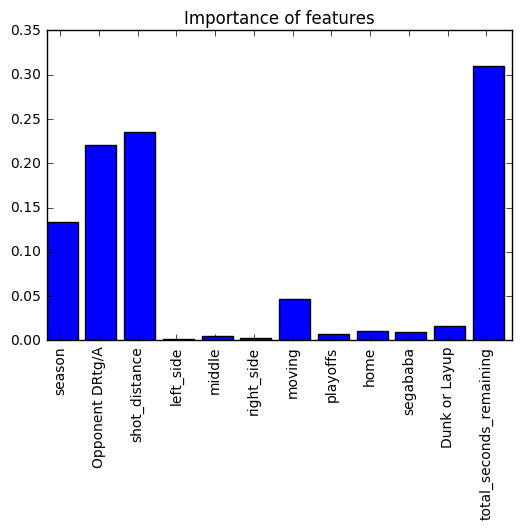

In [138]:
import matplotlib.pyplot as plt
% matplotlib inline
ind = np.arange(len(clf.feature_importances_))
width = 0.35 # Width of bars

fig, ax = plt.subplots()

ax.bar(ind, clf.feature_importances_, color="blue")
ax.set_xticks(ind + width)
ax.set_xticklabels((X.columns.values), rotation='vertical')
ax.set_title('Importance of features')

In [139]:
import operator
feature_map = dict(zip(X.columns.values, clf.feature_importances_))
sorted_feature_map = sorted(feature_map.items(), key=operator.itemgetter(1), reverse=True)
print "Ranking the importances:"
for t in sorted_feature_map:
    print "- {}: {}".format(t[0], t[1])

Ranking the importances:
- total_seconds_remaining: 0.309657633722
- shot_distance: 0.235420812714
- Opponent DRtg/A: 0.220428331893
- season: 0.133954291785
- moving: 0.0468970528072
- Dunk or Layup: 0.0167222217404
- home: 0.0110089025428
- segababa: 0.00937584141525
- playoffs: 0.00735528498837
- middle: 0.00475330835333
- right_side: 0.00232131974789
- left_side: 0.00210499829033


## Results
Surprisingly, the total amount of seconds remaining had the most influence over whether or not the shot was made. TODO - Graph time remaining vs shooting % later and interpret.

As we can see, the shot distance and opponent's defensive rating had the most significance which makes sense. The further away you are from a basket and the quality of the defense are physically the most influential parts of making a shot. 

Next, the season had a significant impact as well. This makes sense because as Kobe got older, his playstyle changed to accommodate his for his increasing/decreasing athleticism.

We also saw impact from whether or not the shot was a dunk or a jump shot and if the shot was taken while he was still moving.

Interestingly, most of the mental aspects have very little impact.

Home games: This was the most influential out of all of the mental aspects. This makes sense - away games are on the road (meaning travel time), away from home crowds and away from the location where Kobe practiced most. I think it would be interesting if there was some sort of exploration for the effect of a crowd on a game. Is this narrative media-manufactured or is it actually true?

Playoffs: This was surprising to me. I assumed that a playoff game would have a significant impact on a shot made, so does this mean that the effect of playoff defense is overstated?

Side of the court: I thought this would have a more significant impact in that Kobe would rather shoot from the spots he's most comfortable with. If the side is changed, then I would have assumed that he was forced to that spot by the defense, and thus be shooting a shot he's less comfortable. However, Kobe was a monster in basketball, so he probably is comfortable taking any shot.

SEGABABA: I assumed that the fatigue of having to play two games in two nights would heavily affect shooting performance. However, this does not seem to be the case as it is one of the least impactful features.